In [70]:
import numpy as np
import pandas as pd

import os
import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import resnet18, resnet50
import torch.nn as nn
import torch.nn.functional as F

import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.miners import BaseMiner

from sklearn.metrics import pairwise_distances

from online_triplet_loss.losses import *

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors


from tqdm.notebook import tqdm

from PIL import Image
import random



from matplotlib import pyplot as plt
import seaborn as sns

import warnings

import logging

warnings.filterwarnings("ignore")

### Prepare dataframe

In [2]:
df_train = pd.read_csv("Stanford_Online_Products/Ebay_train.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [3]:
df_train

,image_id,class_id,super_class_id,path
0,1,1,1,bicycle_final/111085122871_0.JPG
1,2,1,1,bicycle_final/111085122871_1.JPG
2,3,1,1,bicycle_final/111085122871_2.JPG
3,4,1,1,bicycle_final/111085122871_3.JPG
4,5,1,1,bicycle_final/111085122871_4.JPG
...,...,...,...,...
59546,59547,11318,12,toaster_final/221852410489_0.JPG
59547,59548,11318,12,toaster_final/221852410489_1.JPG
59548,59549,11318,12,toaster_final/221852410489_2.JPG
59549,59550,11318,12,toaster_final/221852410489_3.JPG


### Number of classes

In [ ]:
num_classes = len(df_train['class_id'].value_counts())
num_classes

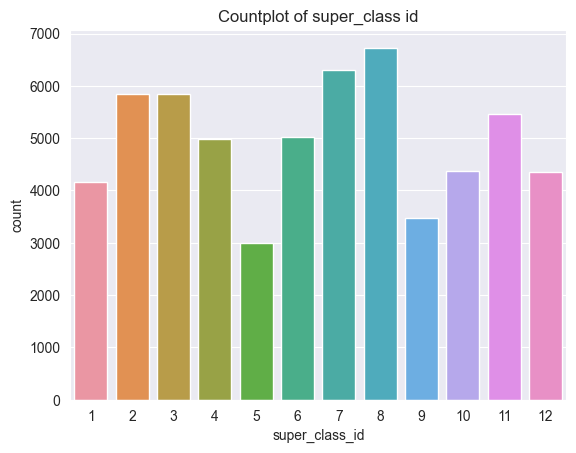

In [4]:
plt.title("Countplot of super_class id")
sns.countplot(data=df_train, x='super_class_id')
plt.show()

### Triplet Loss functions

In [52]:
PATH = "Stanford_Online_Products"
IMAGE_SIZE = 224

In [42]:
# class ProductDataset(Dataset):
#     def __init__(self, df, path, train=True, transform=None):
#         self.data_csv = df
#         self.is_train = train
#         self.transform = transform
#         self.path = path
#         if self.is_train:
#             self.images = df["path"].values
#             self.labels = df["class_id"].values
#             self.index = df.index.values
#
#
#
#     def __len__(self):
#         return len(self.images)
#
#
#     def __getitem__(self, item):
#         anchor_image_name = self.images[item]
#         anchor_image_path = self.path + "/" + anchor_image_name
#         ###### Anchor Image #######
#         anchor_img = Image.open(anchor_image_path).convert("RGB")
#         if self.is_train:
#             anchor_label = self.labels[item]
#             positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]
#             positive_item = random.choice(positive_list)
#             positive_image_name = self.images[positive_item]
#             positive_image_path = self.path + "/" + positive_image_name
#             positive_img = Image.open(positive_image_path).convert("RGB")
#             #positive_img = self.images[positive_item].reshape(28, 28, 1)
#             negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
#             negative_item = random.choice(negative_list)
#             negative_image_name = self.images[negative_item]
#             negative_image_path = self.path + "/" +  negative_image_name
#             negative_img = Image.open(negative_image_path).convert("RGB")
#             #negative_img = self.images[negative_item].reshape(28, 28, 1)
#
#         if self.transform != None:
#             anchor_img = self.transform(anchor_img)
#             positive_img = self.transform(positive_img)
#             negative_img = self.transform(negative_img)
#
#         return anchor_img, positive_img, negative_img, anchor_label
#
#
#
#
#
# train_transform =transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
#         transforms.RandomHorizontalFlip(0.5),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )
#
# val_transform = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )

In [77]:
class ProductDataset(Dataset):
    def __init__(self, df, path, train=True, transform=None):
        self.data_csv = df
        self.is_train = train
        self.transform = transform
        self.path = path
        if self.is_train:
            self.images = df["path"].values
            self.labels = df["class_id"].values
            self.index = df.index.values



    def __len__(self):
        return len(self.images)


    def __getitem__(self, item):
        anchor_image_name = self.images[item]
        anchor_image_path = self.path + "/" + anchor_image_name
        ###### Anchor Image #######
        anchor_img = Image.open(anchor_image_path).convert("RGB")
        if self.is_train:
            anchor_label = self.labels[item]


        if self.transform != None:
            anchor_img = self.transform(anchor_img)


        return anchor_img, anchor_label





train_transform =transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [78]:
trainDS = ProductDataset(df=df_train, path=PATH, train=True, transform=train_transform)

In [79]:
BATCH_SIZE = 128

In [80]:
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)

In [81]:
images, labels = next(iter(trainLoader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


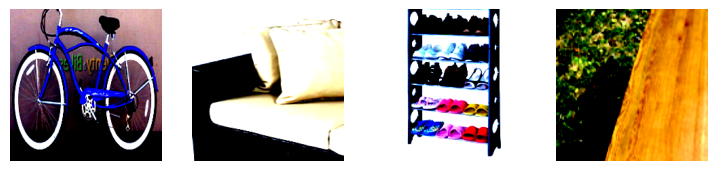

In [82]:
plt.figure(figsize=(9, 40))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
plt.show()

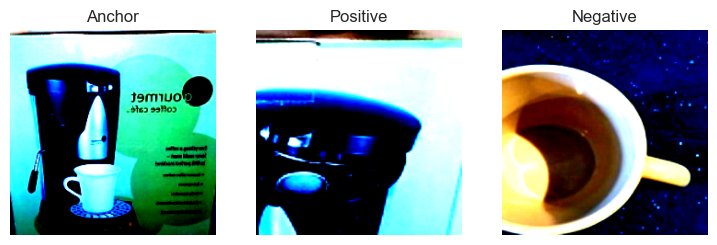

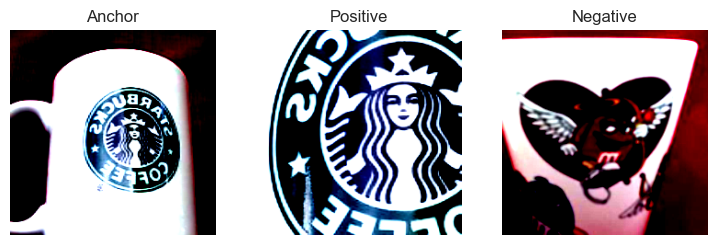

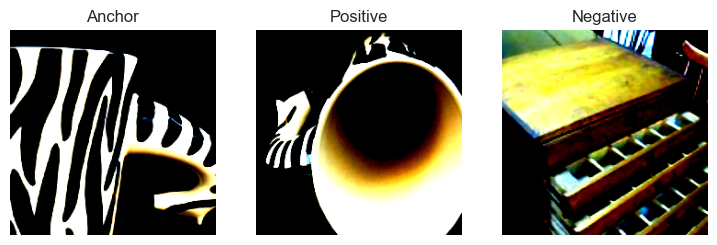

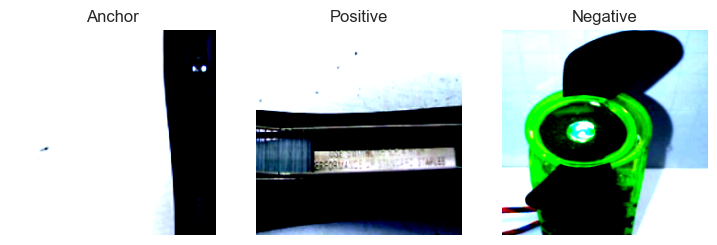

In [13]:
# for i in range(4):
#
#     plt.figure(figsize=(9,18))
#     plt.subplot(1,3,1)
#     plt.imshow(anchors[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Anchor")
#
#     plt.subplot(1,3,2)
#     plt.imshow(positives[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Positive")
#
#     plt.subplot(1,3,3)
#     plt.imshow(negatives[i].permute(1, 2, 0))
#     plt.axis("off")
#     plt.title("Negative")
#
#     plt.show()

In [83]:
EMBED_DIMS = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 0.0001
EPOCHS = 20

In [84]:
class ResNet_Triplet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Feature_Extractor = resnet50(pretrained=True)
        num_filters = self.Feature_Extractor.fc.in_features
        self.Feature_Extractor.fc = nn.Sequential(
                  nn.Linear(num_filters,512),
                  nn.ReLU(),
                  nn.Linear(512,EMBED_DIMS))


    def forward(self,x):
        x = self.Feature_Extractor(x)
        x = F.normalize(x, p=2, dim=1)

        return x

In [85]:
model = ResNet_Triplet()
# model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)

In [86]:
# Set the loss function
criterion = losses.TripletMarginLoss(margin=0.2)

In [87]:
models = {"trunk": model}
optimizers = {"trunk_optimizer": optimizer}
loss_funcs = {"metric_loss": criterion}

In [89]:
df_train[['super_class_id','class_id']]

,super_class_id,class_id
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
59546,12,11318
59547,12,11318
59548,12,11318
59549,12,11318


In [88]:
miner = miners.BatchEasyHardMiner(
        pos_strategy="hard",
        neg_strategy="hard")

sampler = samplers.HierarchicalSampler(
        labels = df_train[['super_class_id','class_id']],
        batch_size = BATCH_SIZE,
        samples_per_class = 2,
        batches_per_super_tuple=4,
        super_classes_per_batch=2,
        inner_label=0,
        outer_label=1,
    )

In [ ]:
trainers.BaseTrainer(models = models,
                    optimizers = optimizers,
                    batch_size = BATCH_SIZE,
                    loss_funcs = loss_funcs,
                    dataset = trainDS,
                    mining_funcs=miner,
                    sampler=None,
                    collate_fn=None,
                    lr_schedulers=None,
                    gradient_clippers=None,
                    freeze_these=(),
                    freeze_trunk_batchnorm=False,
                    label_hierarchy_level=0,
                    dataloader_num_workers=2,
                    data_and_label_getter=None,
                    dataset_labels=None,
                    set_min_label_to_zero=False,
                    end_of_iteration_hook=None,
                    end_of_epoch_hook=None)

In [71]:
for epoch in tqdm(range(EPOCHS)):
    running_loss = []
    for step, (images, labels) in enumerate(tqdm(trainLoader)):

        embeddings = model(images)
        optimizer.zero_grad()

        loss = batch_hard_triplet_loss(labels, embeddings, squared=False, margin=1.0)

        loss.backward()
        optimizer.step()
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} — Loss: {:.4f}".format(epoch+1, EPOCHS, np.mean(running_loss)))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 1/20 — Loss: 1.0338


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 2/20 — Loss: 1.0019


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 3/20 — Loss: 1.0009


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 4/20 — Loss: 1.0007


  0%|          | 0/233 [00:00<?, ?it/s]

Epoch: 5/20 — Loss: 1.0007


  0%|          | 0/233 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
torch.save(model, "models/model.pts")

In [73]:
model = torch.load("models/model.pts")

In [74]:
model

ResNet_Triplet(
  (Feature_Extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

### Visualise latent space

#### Find training embeddings

In [75]:
model.eval()

train_embeddings = []
train_labels = []
for images, labels in trainLoader:
    batch_embedings = model(images)
    train_embeddings.extend(batch_embedings.cpu().detach().numpy())
    train_labels.extend(labels.numpy())

Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "D:\Epam\CV\MetricsLearning\venv\Lib\site-packages\ipykernel\iostream.py", line 646, in write
    self._schedule_flush()
  File "D:\Epam\CV\MetricsLearning\venv\Lib\site-packages\ipykernel\iostream.py", line 543, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "D:\Epam\CV\MetricsLearning\venv\Lib\site-packages\ipykernel\iostream.py", line 249, in schedule
    self._event_pipe.send(b"")
  File "D:\Epam\CV\MetricsLearning\venv\Lib\site-packages\zmq\sugar\socket.py", line 696, in send
    return super().send(data, flags=flags, copy=copy, track=track)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "zmq\backend\cython\socket.pyx", line 742, in zmq.backend.cython.socket.Socket.send
  File "zmq\backend\cython\socket.pyx", line 789, in zmq.backend.cython.socket.Socket.send
  File "zmq\backend\cython\so

KeyboardInterrupt: 

In [20]:
train_embeddings.shape

torch.Size([1, 300])

In [36]:
train_embeddings

In [ ]:
def visualise(X, labels):
    X_reduced = TSNE(n_components=2).fit_transform(X)
    palette = np.array(sns.color_palette("hls", num_classes))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=palette[labels])
    plt.show()

In [ ]:
### Test

In [ ]:
df_test = pd.read_csv("Stanford_Online_Products/Ebay_test.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])

In [ ]:
df_test

In [ ]:
df_test.shape

In [ ]:
testDS = ProductDataset(df=df_test, path=PATH, train=False, transform=val_transform)

In [ ]:
testLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model.eval()

test_embeddings = []
test_labels = []
for images, labels in trainLoader:
    batch_embedings = model(images)
    test_embeddings.extend(batch_embedings.cpu().detach().numpy())
    test_labels.extend(labels.numpy())

In [ ]:
### Find nearest neighbours

In [ ]:
#get embeddings of all test images
embeddings = model(all_images)

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
knn.fit(embeddings)  #all vectors

In [ ]:
image = images[10] # take an existing image or create a numpy array from PIL image
image = np.expand_dims(image, 0) # add a batch dimension
query_embedding = model(image)

distances, nbors = knn.kneighbors(query_embedding)
# output is a tuple of list of distances and list nbors of each image
# so we take the first entry from those lists since we have only one image
distances, nbors = distances[0], nbors[0]

nbor_images = [images[i] for i in nbors]
fig, axes = plt.subplots(1, len(nbors)+1, figsize=(10, 5))

for i in range(len(nbor_images)+1):
    ax = axes[i]
    ax.set_axis_off()
    if i == 0:
        ax.imshow(image.squeeze(0))
        ax.set_title("Input")
    else:
        ax.imshow(nbor_images[i-1])
        # we get cosine distance, to convert to similarity we do 1 - cosine_distance
        ax.set_title(f"Sim: {1 - distances[i-1]:.2f}")

In [ ]:
df_test = pd.read_csv("Stanford_Online_Products/Ebay_test.txt", sep=' ', skiprows=1, names=["image_id", "class_id", "super_class_id", "path"])